In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import h5py
import glob


from mockobservation_tools.sersic_tools import fit_sersic
from mockobservation_tools.general_tools import measure_surfbright
from mockobservation_tools.galaxy_tools import ParamsFromPath

%matplotlib inline



Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


## This goes through using fitting a 1d and 2d sersic profile to images



### Sersic2D Function

Overview of the astropy Sersic2D model

amplitude : Surface brightness at r_eff \
r_eff     : Effective (half-light) radius \
n         : Sersic Index \
x_0, y_0: Center coordinates \
ellip     : Ellipticity \
theta     : Rotation angle in radians, counterclockwise from the positive x-axis

#### Code taken from astropy that executes the Sersic2D model
def evaluate(cls, x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta):
        """Two dimensional Sersic profile function."""

        if cls._gammaincinv is None:
            try:
                from scipy.special import gammaincinv
                cls._gammaincinv = gammaincinv
            except ValueError:
                raise ImportError('Sersic2D model requires scipy.')

        bn = cls._gammaincinv(2. * n, 0.5)
        a, b = r_eff, (1 - ellip) * r_eff
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
        x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
        z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

        return amplitude * np.exp(-bn * (z ** (1 / n) - 1))



#### Overview of the code
The major axis (a) is used as r_eff. \
The minor axis (b) is scaled based on the ellipticity (e) of the fit. \
The axis is rotated by theta counterclockwise from the positive x-axis to the major axis of the fit. \
The new x-axis is aligned with the major axis of the fit (x_maj) \
The new y-axis is aligned with the minor axis of the fit (x_min) \
The rotation is a typical axis roation: x' = x cos$\theta$ + y sin$\theta$, y' = -x cos$\theta$ + y cos$\theta$

The equation used in Sersic2D: 
$$ A e^{-bn  [z^{(1 / n)} - 1)]}$$

The equation used in Sersic1D: 
$$ A e^{-bn  [(r / Re)^{(1 / n)} - 1)]}$$

Although both use bn, in Sersic2D they use the Γ(2𝑛)=2𝛾(2𝑛,𝑏𝑛), \
The general Sersic bn I have used uses the approximation: \
bn = 2n - 0.327 approximation for 0.5 < n < 10

$z = \sqrt{(x_{maj} / a)^2 + (x_{min} / b)^2}$ which is the 2D equivelent to r / Re


###### Note: When n = 1 that is equivalent to exponential decay

In [2]:
# Read in an image
#collect all of the image files from the directory

savedirectory = 'Figures/'

images_files = glob.glob(savedirectory + "*.hdf5")
images_files

file = h5py.File(images_files[0], 'r')

rband_image = file['projection_xy']['band_r'][:]


In [3]:
galaxyID, FOV, pixel = ParamsFromPath(images_files[0], typeint=False) # this only works if you use my file naming 
print(FOV)
print(pixel)
FOV = int(FOV)
pixel = int(pixel)

25
500


## Example 1D sersic fit

sersic_type = 'sersic' uses my function for sersic profile\
sersic_type = 'sersic1D' uses scipys funtions

they are essentially the same, I usually use 'sersic'

In [4]:
# measure the surface brightness from the center outwards
# nmeasure is the number of point it measures
# FOV is the kpc for the radius of the image

radius,surfacebrightness = measure_surfbright(rband_image,FOV=FOV, nmeasure=100)


---------------------------------------------
sersic
Effective Intensity: 1.68e+07 Lsun
Effective Radius:    1.69 kpc
Sersic Index:        0.71
---------------------------------------------
sersic1D
Effective Intensity: 1.67e+07 Lsun
Effective Radius:    1.70 kpc
Sersic Index:        0.71


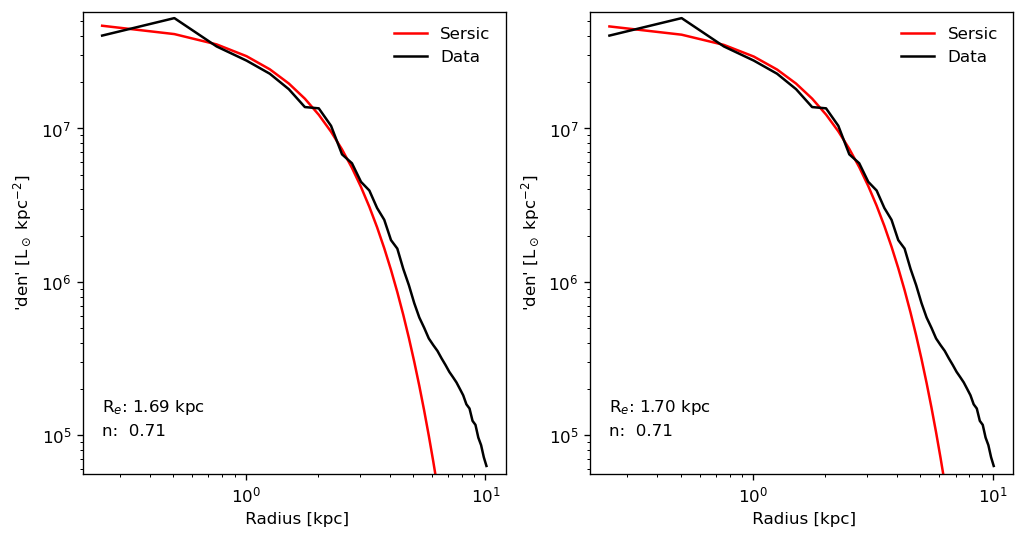

In [5]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))


params, std = fit_sersic(radius,surfacebrightness,FOV=FOV,sersic_type='sersic',ax_sersic=axs[0])
print('---------------------------------------------')
print('sersic')

print(f'Effective Intensity: {params[0]:.2e} Lsun')
print(f'Effective Radius:    {params[1]:.2f} kpc')
print(f'Sersic Index:        {params[2]:.2f}')

params, std = fit_sersic(radius,surfacebrightness,FOV=FOV,sersic_type='sersic1D',ax_sersic=axs[1])

print('---------------------------------------------')
print('sersic1D')

print(f'Effective Intensity: {params[0]:.2e} Lsun')
print(f'Effective Radius:    {params[1]:.2f} kpc')
print(f'Sersic Index:        {params[2]:.2f}')



## 2d Sersic profile

'sersic2D' fit a sersic to the image itself

Now you use fit_sersic with an input image and sersic_type='sersic2D'

---------------------------------------------
sersic1D
Effective Intensity: 1.23e+07 Lsun
Effective Radius:    2.17 kpc
Sersic Index:        0.98
Ellipticity:         0.27
Position Angle:      2.33


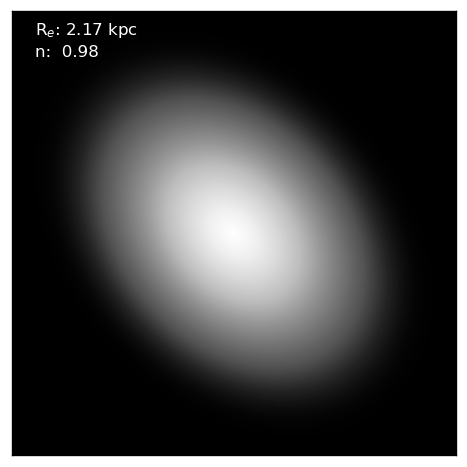

In [6]:
#If you want to do 2d 
#input an image instead of radius and surfacebrightness
#change the sersic type to 'sersic2D'


popt,std = fit_sersic(image=rband_image,FOV=FOV,sersic_type='sersic2D',
                      ax_sersic=plt.gca())


print('---------------------------------------------')
print('sersic1D')

print(f'Effective Intensity: {popt[0]:.2e} Lsun')
print(f'Effective Radius:    {popt[1]:.2f} kpc')
print(f'Sersic Index:        {popt[2]:.2f}')
print(f'Ellipticity:         {popt[5]:.2f}')
print(f'Position Angle:      {popt[6]:.2f}')

ellip = popt[5]
angle = popt[6]

## You can also do a 1D sersic fit but use ellipses 

In [7]:
radiusell,surfacebrightnessell = measure_surfbright(rband_image,ellip=ellip,theta=angle,
                                              FOV=FOV, nmeasure=100)


---------------------------------------------
Circular sersic
Effective Intensity: 1.68e+07 Lsun
Effective Radius:    1.69 kpc
Sersic Index:        0.71
---------------------------------------------
Elliptical sersic
Effective Intensity: 1.48e+07 Lsun
Effective Radius:    2.06 kpc
Sersic Index:        0.81


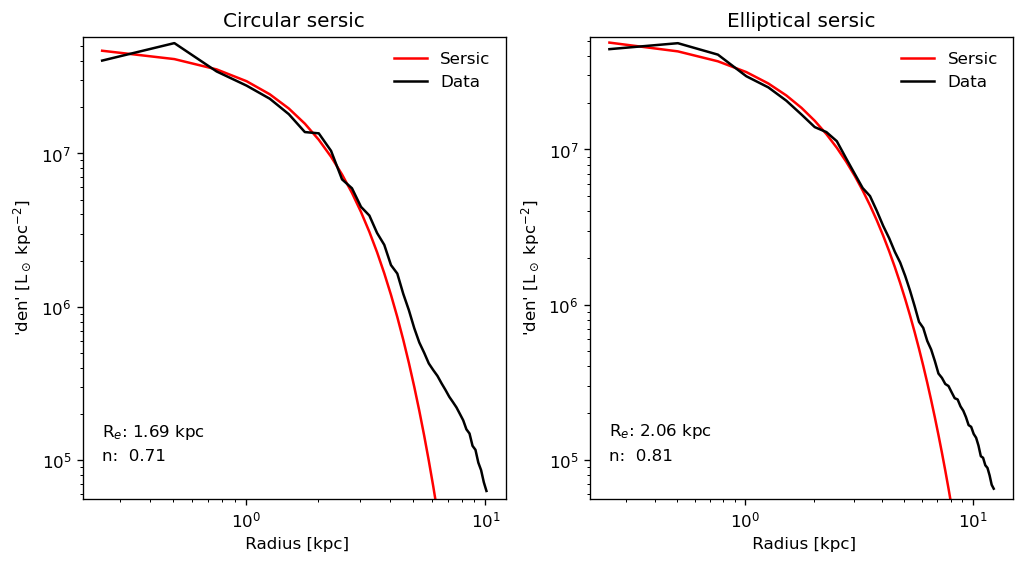

In [8]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))

axs[0].set_title('Circular sersic')
params, std = fit_sersic(radius,surfacebrightness,FOV=FOV,sersic_type='sersic',ax_sersic=axs[0])
print('---------------------------------------------')
print('Circular sersic')

print(f'Effective Intensity: {params[0]:.2e} Lsun')
print(f'Effective Radius:    {params[1]:.2f} kpc')
print(f'Sersic Index:        {params[2]:.2f}')

axs[1].set_title('Elliptical sersic')
params, std = fit_sersic(radiusell,surfacebrightnessell,FOV=FOV,sersic_type='sersic',ax_sersic=axs[1])

print('---------------------------------------------')
print('Elliptical sersic')

print(f'Effective Intensity: {params[0]:.2e} Lsun')
print(f'Effective Radius:    {params[1]:.2f} kpc')
print(f'Sersic Index:        {params[2]:.2f}')
